In [1]:
from pyfermions import *
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal, scipy.linalg, scipy.interpolate
import matplotlib

# Biorthogonal wavelets and filter construction

Some of the pyfermions code copied with the adapted design problem, and with a not-so-elegant class for biorthogonal wavelets. What I call $h$ and $g$ is probably not consistent.

In [2]:
class biorthogonal_wavelet:
    """
    Biorthogonal wavelet consisting of a pair of scaling (low-pass) filters and a pair of wavelet (high-pass)
    filters.
    """

    def __init__(self, scaling_filters, wavelet_filters):
        #: Scaling filters (low-pass filters).
        self.scaling_filters = scaling_filters

        #: Wavelet filters (high-pass filter).
        self.wavelet_filters = wavelet_filters

    @staticmethod
    def from_scaling_filters(scaling_filters):
        """Construct orthogonal wavelet from scaling filter."""
        # could also use scipy.signal.qmf() and translate manually
        wavelet_filters = [
            -s.conj().modulate(-1.0).shift(-1).reverse() for s in scaling_filters[::-1]
        ]

        return biorthogonal_wavelet(scaling_filters, wavelet_filters)

    @staticmethod
    def from_wavelet_filters(wavelet_filters):
        """Construct orthogonal wavelet from wavelet filter."""
        scaling_filters = [
            -w.reverse().shift(1).modulate(-1.0).conj() for w in wavelet_filters[::-1]
        ]
        return biorthogonal_wavelet(scaling_filters, wavelet_filters)

    def analyze(self, i, s):
        """Decompose signal into scaling and wavelet coefficients."""
        scaling = s.convolve(self.scaling_filters[i].reverse()).downsample()
        wavelet = s.convolve(self.wavelet_filters[i].reverse()).downsample()
        return (scaling, wavelet)

    def reconstruct(self, i, scaling=None, wavelet=None):
        """Reconstruct signal from scaling and wavelet coefficients."""
        assert i in [0, 1]
        if scaling is None:
            scaling = signal()
        if wavelet is None:
            wavelet = signal()
        return scaling.upsample().convolve(
            self.scaling_filters[i]
        ) + wavelet.upsample().convolve(self.wavelet_filters[i])

    def scaling_functions(self, L):
        """Return scaling functions at dyadic approximation 2^{-L}."""
        s0 = self._casade(L, 0, scaling=signal([1]))
        s1 = self._casade(L, 1, scaling=signal([1]))
        return (
            s0.range * 2 ** -L,
            s0.data * 2 ** (L / 2),
            s1.range * 2 ** -L,
            s1.data * 2 ** (L / 2),
        )

    def wavelet_functions(self, L):
        """Return wavelet functions at dyadic approximation 2^{-L}."""
        s0 = self._casade(L, 0, wavelet=signal([1]))
        s1 = self._casade(L, 1, wavelet=signal([1]))
        return (
            s0.range * 2 ** -L,
            s0.data * 2 ** (L / 2),
            s1.range * 2 ** -L,
            s1.data * 2 ** (L / 2),
        )

    def _casade(self, L, i, wavelet=None, scaling=None):
        """Starting from scaling and wavelet coefficients at level L, return output of inverse wavelet transform."""
        # there is some numerical instability in scipy's implementation of the cascade algorithm (as compared to our code
        # below and to Matlab's wavefun); otherwise we could simply use scipy.signal.cascade(self.scaling_filter.data, L)
        assert i in [0, 1]
        s = self.reconstruct(i, scaling=scaling, wavelet=wavelet)
        for l in range(L - 1):
            s = self.reconstruct(i, scaling=s)
        return s

Selesnick-inspired "common factor" construction of biorthogonal wavelets for a given phase relation $A(z)/B(z)$; see Appendix B of our paper.

In [3]:
def common_factor_biorth_wlet(a, b, K, min_phase=False):
    """
    Returns Selesnick's type common factor biorthogonal wavelet pair.

    The parameter K determines the number of zeros at z=-1.
    The pair a, b should be equal length arrays such that A(z)/B(z) implements the desired
    phase relation.

    The length of both scaling filters is 2(K+M) where M = len(a) - 1.
    This code is inspired by Selesnick's hwlet.m.
    """
    assert np.size(a) == np.size(b)
    M = np.size(a) - 1

    # filter for z^(K+L) S(z) (some other shift)
    s1 = scipy.special.binom(2 * K, np.arange(2 * K + 1))
    s2 = np.convolve(a, b)
    s = np.convolve(s1, s2)

    # solve convolution system for z^(K+L-1) R(z) (other shift)
    A = convmtx(s, 2 * (K + M) - 1)
    A = A[1::2]
    x = np.zeros(2 * (K + M) - 1)
    x[K + M - 1] = 1
    A_norm = np.linalg.norm(A)  # to increase stability
    r = np.linalg.solve(A / A_norm, x) / A_norm
    
    # symmetrize and check that still solution
    r = (r + r[::-1].conj()) / 2
    assert np.allclose(A @ r, x)

    # find spectral factor Q(z) and compute filter for z^K F(z)
    q = sfact(r, min_phase=min_phase)
    c = scipy.special.binom(K, np.arange(K + 1))
    f = np.convolve(q, c)
    g = np.convolve(f, b)
    h = np.convolve(f, a)

    # build orthogonal wavelet pair
    return biorthogonal_wavelet.from_scaling_filters([signal(g), signal(h)])

The following function constructs a biorthogonal wavelet based on a systematic way of approximating the phase relation for the **massless** harmonic chain; see Appendix B of our paper.

In [4]:
def massless_harmonic_biorth_wlet(K, L, min_phase=False):
    """
    Returns biorthogonal wavelet pair, where the phase relation
    is implemented as a combination of all-pass filters.

    The parameter K determines the number of zeros at z=-1.
    The parameter L determines the approximation of the phase relation.

    The length of both scaling filters is 2(K+2L).
    """
    d = allpass(1 / 2, L)
    a = (np.convolve(d, d) + np.convolve(d[::-1], d[::-1])) / 2
    b = np.convolve(d, d[::-1])

    return common_factor_biorth_wlet(a, b, K, min_phase=min_phase)


massless_harmonic_biorth_wlet(5, 5)

We also provide a (somewhat ad-hoc) variational procedure for finding biorthogonal wavelets for any value of the mass. This code is not used in the following.

In [5]:
def symmetrize(s):
    N = np.size(s)
    return signal(s[::-1], start=-N + 1) + signal(s)


def rational_cosine(k, a, b):
    return np.real(
        symmetrize([1 - np.sum(a)] + a).ft(k) / symmetrize([1 - np.sum(b)] + b).ft(k)
    )


def rational_phase_approximation(L, mass, eps):
    rational = lambda *args: rational_cosine(args[0], list(args[1:L]), list(args[L:]))
    k = np.arange(-np.pi + eps, np.pi - eps, 0.01)
    y = np.sqrt(mass ** 2 + np.cos(k / 2) ** 2) / np.sqrt(mass ** 2 + 1)
    p0 = (2 * L - 2) * (1 / L,)
    parameters, cov = scipy.optimize.curve_fit(rational, k, y, p0=p0)
    a = list(parameters[: L - 1])
    b = list(parameters[L - 1 :])
    a = symmetrize([1 - np.sum(a)] + a).data
    b = symmetrize([1 - np.sum(b)] + b).data
    return a, b


def variational_harmonic_biorth_wlet(K, L, mass=0, min_phase=False, eps=0.1):
    """
    Returns biorthogonal wavelet pair, where the phase relation
    is implemented by fitting a quotient A(e^ik)/B(e^ik) of trigonometric functions
    to the desired phase relation.

    In order for the construction to work, we constrain A and B to be symmetric.

    The parameter K determines the number of zeros at z=-1.
    The parameter L determines the approximation of the phase relation.

    The length of both scaling filters is 2(K + 2L - 2).
    """
    # this is very ad hoc, it turns out to work for L = 3,5,7
    a, b = rational_phase_approximation(L, mass=mass, eps=eps)

    return common_factor_biorth_wlet(a, b, K, min_phase=min_phase)

variational_harmonic_biorth_wlet(3, 3, 1.23)

Plot the wavelets constructed by `massless_harmonic_biorth_wlet` for $K=2$ and $L=4$:

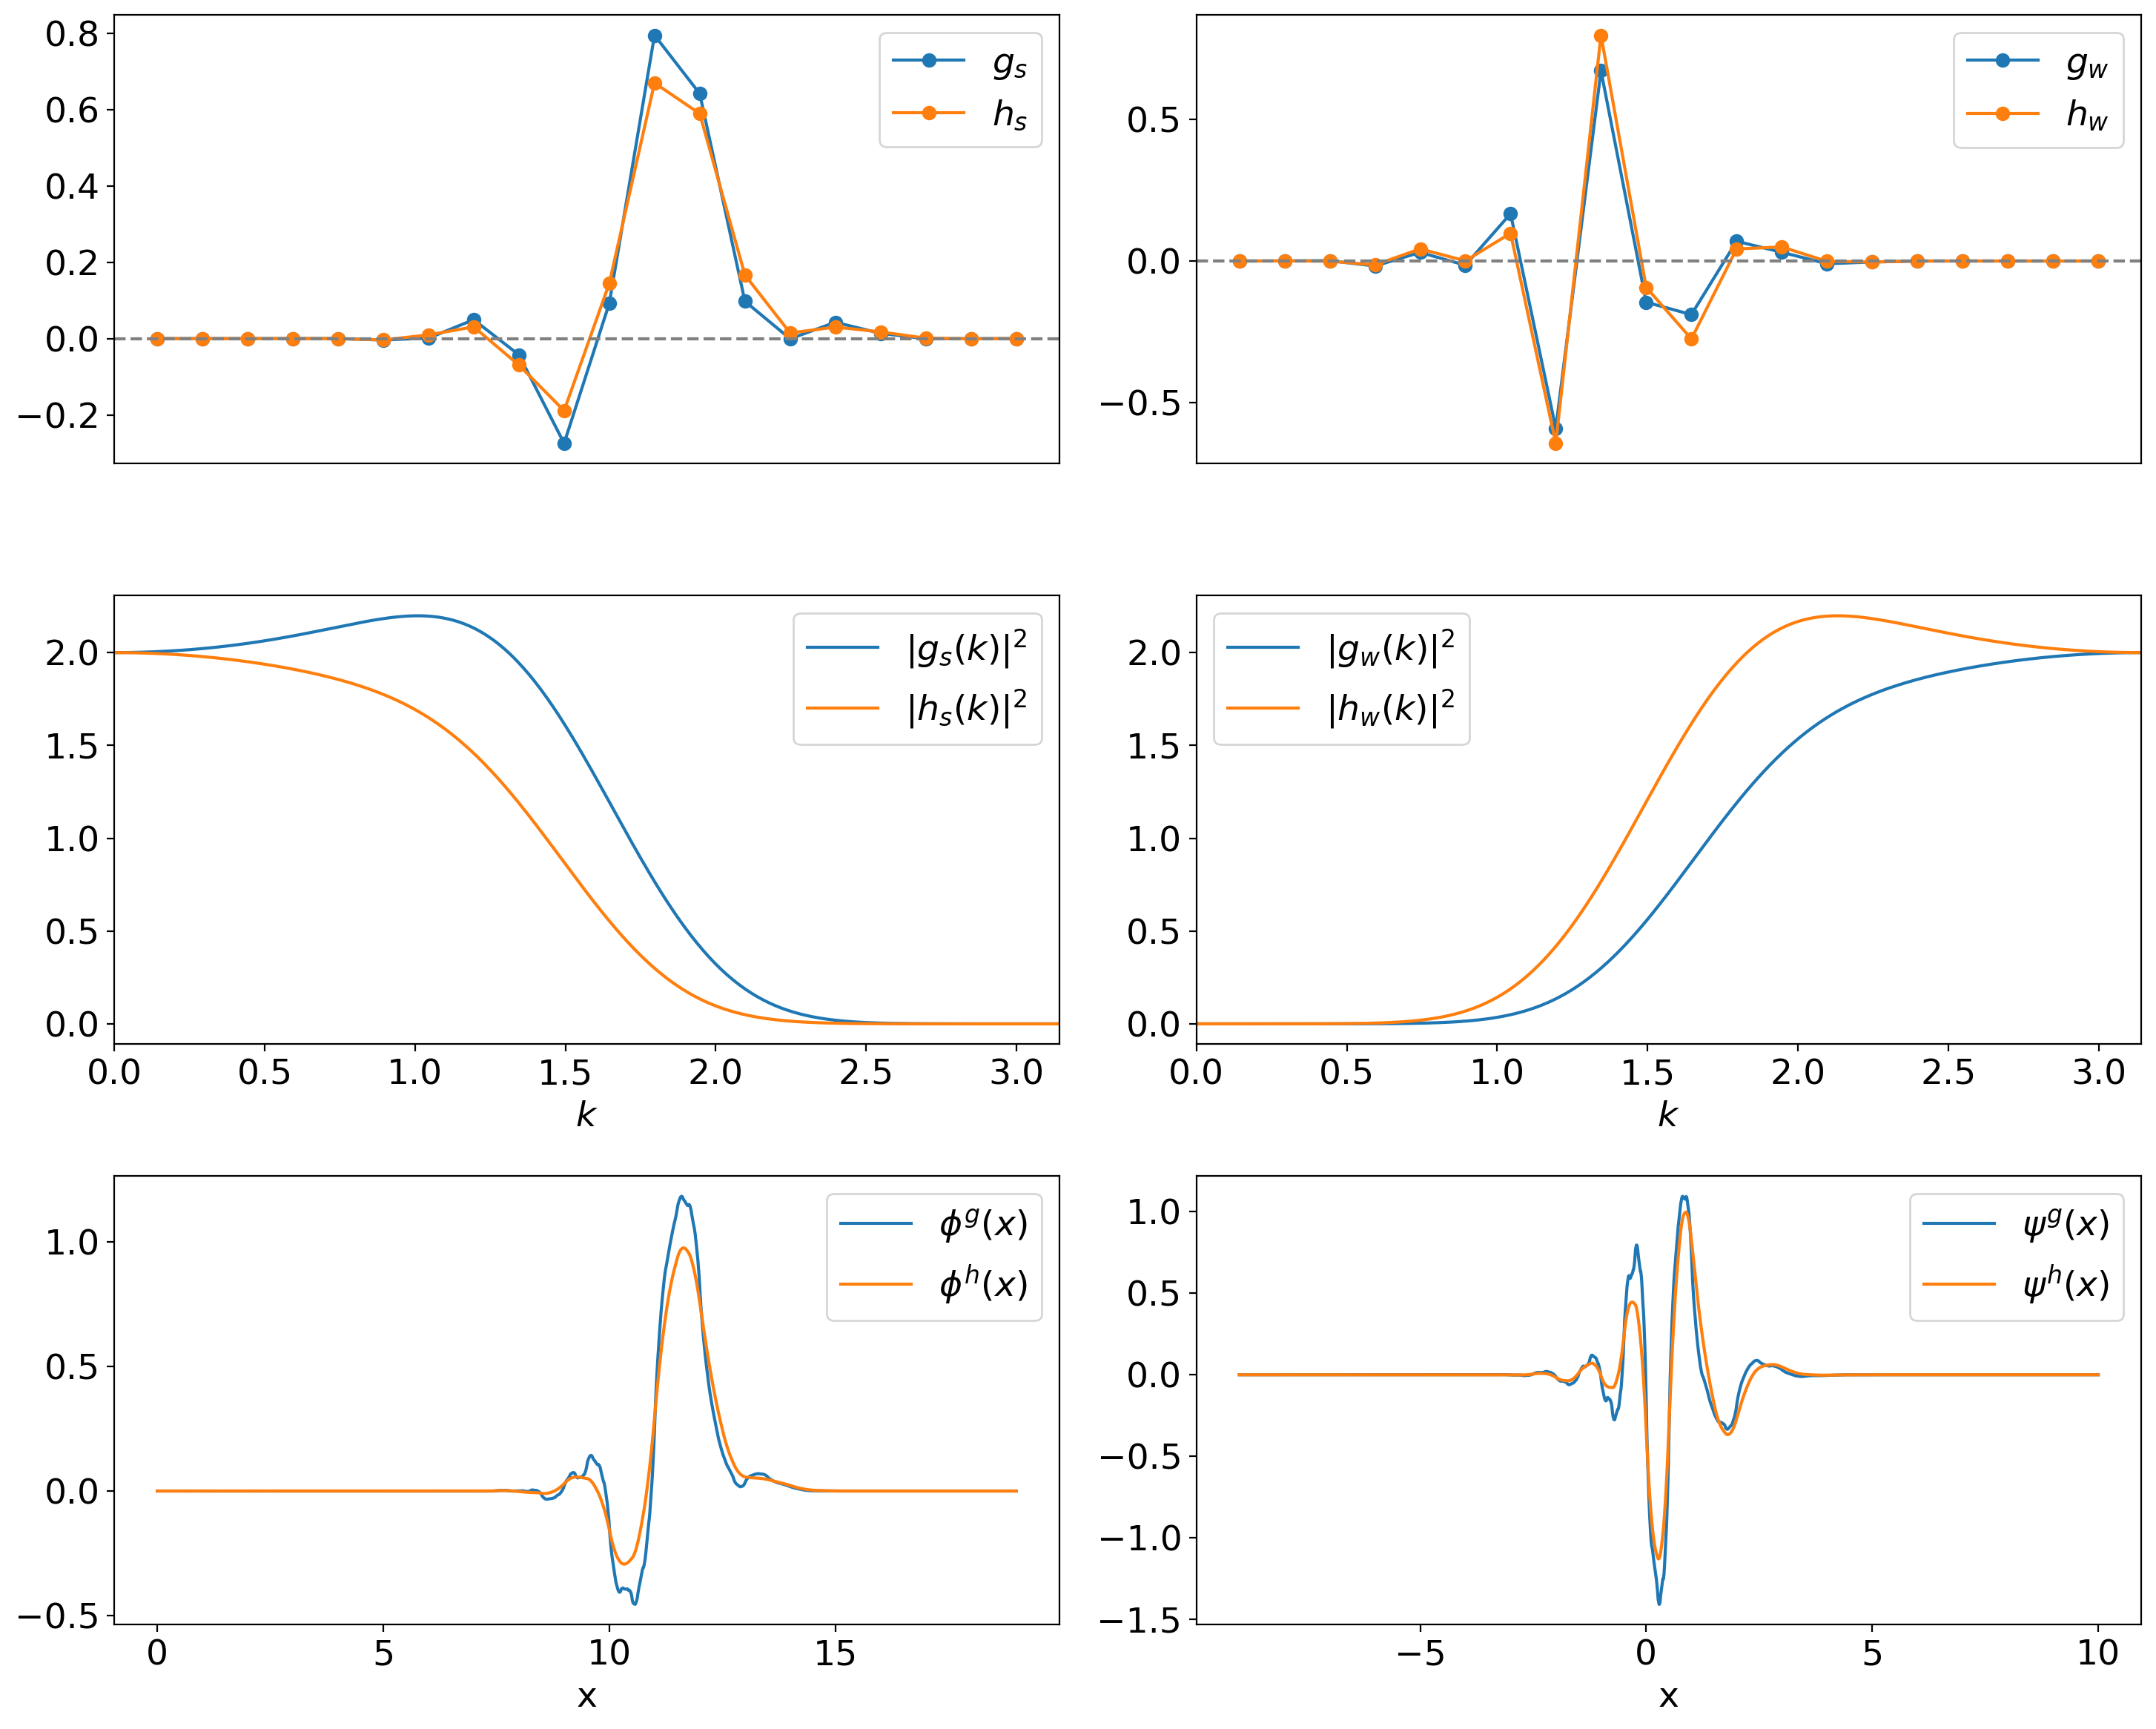

In [6]:
NUM_CASCADE_LEVELS = 16

def show_wavelets(wav):
    s = wav.scaling_filters
    w = wav.wavelet_filters
    fig = plt.figure(figsize=(15, 12))

    plt.subplot(321)
    plt.plot(s[0].range, s[0].data, "-o", label=r"$g_s$")
    plt.plot(s[1].range, s[1].data, "-o", label=r"$h_s$")
    plt.axhline(0, ls="--", color=".5")
    plt.xticks([])
    plt.legend()

    plt.subplot(322)
    plt.plot(w[0].range, w[0].data, "-o", label=r"$g_w$")
    plt.plot(w[1].range, w[1].data, "-o", label=r"$h_w$")
    plt.axhline(0, ls="--", color=".5")
    plt.xticks([])
    plt.legend()

    plt.subplot(323)
    k = np.arange(-np.pi, np.pi, 0.01)
    plt.plot(k, np.abs(s[0].ft(k)) ** 2, label=r"$|g_s(k)|^2$")
    plt.plot(k, np.abs(s[1].ft(k)) ** 2, label=r"$|h_s(k)|^2$")
    plt.xlim(0, np.pi)
    plt.xlabel(r"$k$")
    plt.legend()

    plt.subplot(324)
    plt.plot(k, np.abs(w[0].ft(k)) ** 2, label=r"$|g_w(k)|^2$")
    plt.plot(k, np.abs(w[1].ft(k)) ** 2, label=r"$|h_w(k)|^2$")
    plt.xlim(0, np.pi)
    plt.xlabel(r"$k$")
    plt.legend()

    # scaling functions
    plt.subplot(325)
    x_g, phi_g, x_h, phi_h = wav.scaling_functions(NUM_CASCADE_LEVELS)
    plt.plot(x_g, phi_g, label=r"$\phi^g(x)$")
    plt.plot(x_h, phi_h, label=r"$\phi^h(x)$")
    plt.xlabel("x")
    plt.legend()

    # wavelet functions
    plt.subplot(326)
    x_g, psi_g, x_h, psi_h = wav.wavelet_functions(NUM_CASCADE_LEVELS)
    plt.plot(x_g, psi_g, label=r"$\psi^g(x)$")
    plt.plot(x_h, psi_h, label=r"$\psi^h(x)$")
    plt.xlabel("x")
    plt.legend()

    fig.tight_layout()
    fig.savefig('filters.pdf')

font = {"family": "DejaVu Sans", "weight": "normal", "size": 17}
matplotlib.rc("font", **font)

wav = massless_harmonic_biorth_wlet(K=2, L=4)
show_wavelets(wav)

Show the $\ell^\infty$ error for (i) the wavelet filter phase relation and (ii) the wavelet function phase relation for various values of $K$ and $L$:

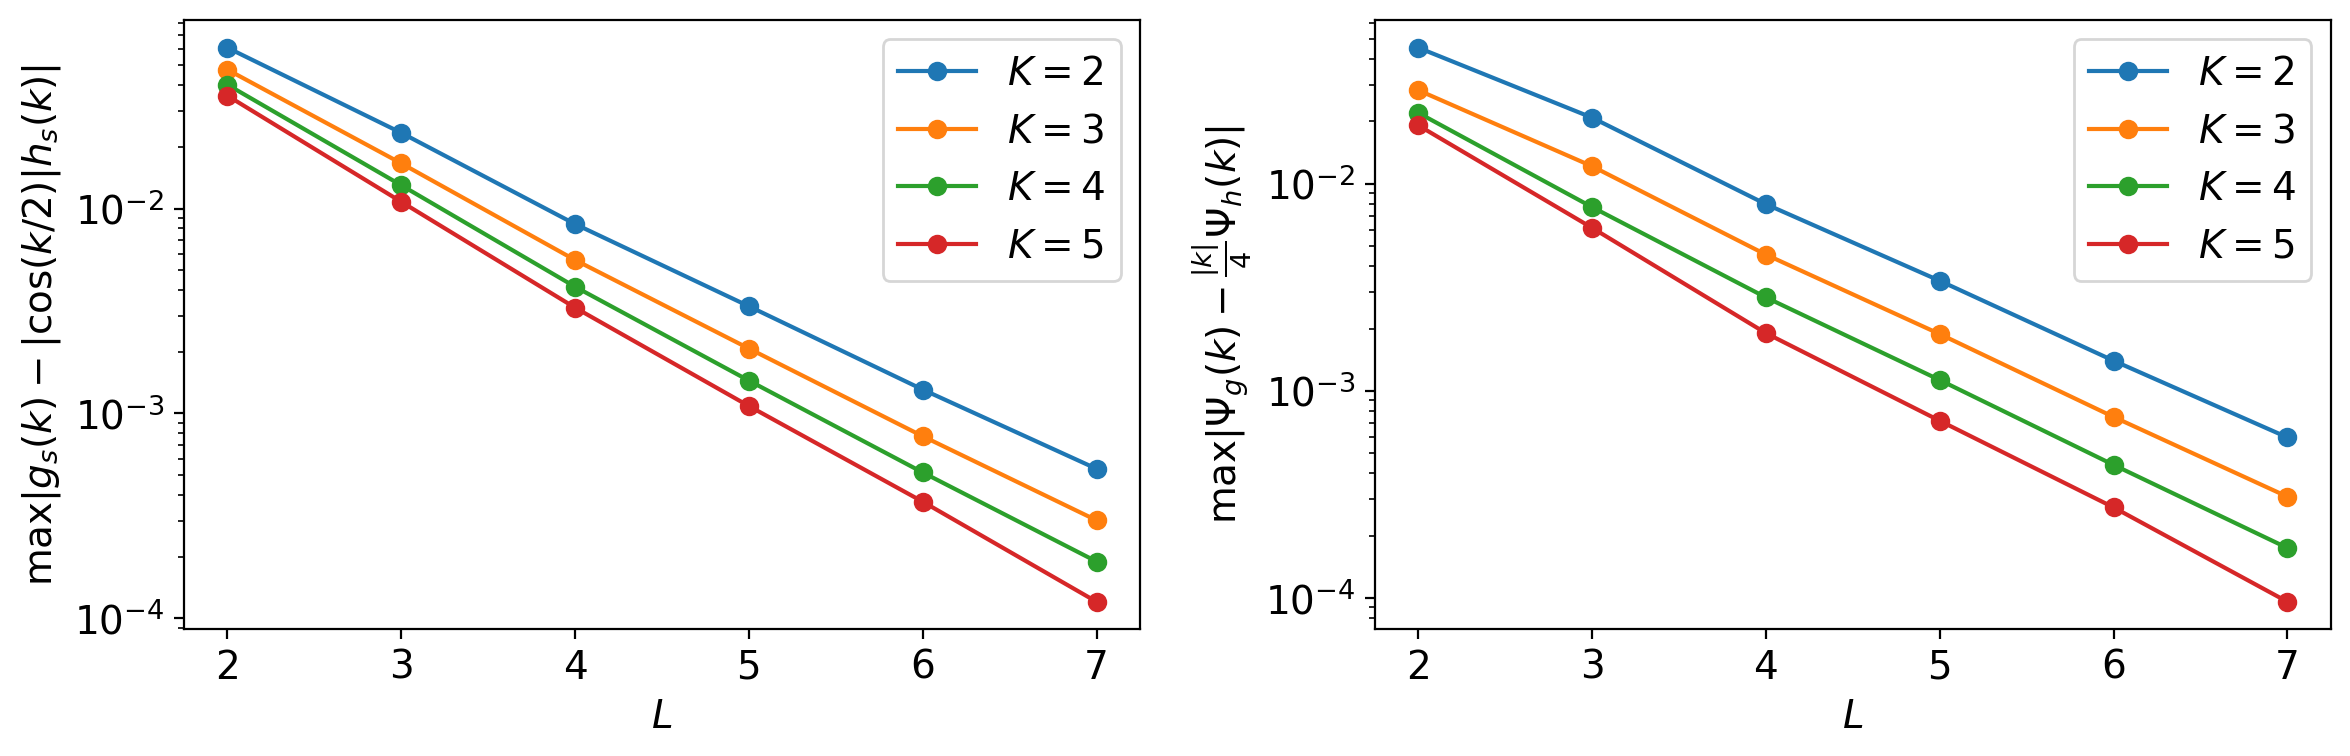

In [7]:
K_values = np.arange(2, 6)
L_values = np.arange(2, 8)
NUM_CASCADE_LEVELS = 16

font = {"family": "DejaVu Sans", "weight": "normal", "size": 14}
matplotlib.rc("font", **font)

fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
for K in K_values:
    diff_Psi = []
    diff_S = []
    for L in L_values:
        wav = massless_harmonic_biorth_wlet(K, L)

        # wavelet functions
        x_h, psi_h, x_g, psi_g = wav.wavelet_functions(NUM_CASCADE_LEVELS)
        omega, Psi_h = ctft(x_h, psi_h, omega_max=8 * np.pi)
        omega_g, Psi_g = ctft(x_g, psi_g, omega_max=8 * np.pi)
        assert np.allclose(omega, omega_g)
        diff_Psi.append(np.max(np.abs(Psi_h - np.abs(omega) * Psi_g / 4)))

        # scaling filters
        h_s, g_s = wav.scaling_filters
        k = np.arange(-np.pi, np.pi, 0.001)
        H_s, G_s = h_s.ft(k), g_s.ft(k)
        diff_S.append(np.max(np.abs(G_s - np.cos(k / 2) * H_s)))

    # plot
    ax[0].set_xlabel("$L$")
    ax[0].set_ylabel(r"$\max\vert g_s(k) - \vert\cos(k/2)\vert h_s(k) \vert$")
    ax[0].semilogy(L_values, diff_S, "-o", label="$K = %d$" % K)
    ax[0].legend()

    ax[1].set_xlabel("$L$")
    ax[1].set_ylabel(r"$\max\vert \Psi_g(k) - \frac{|k|}{4} \Psi_h(k) \vert$")
    ax[1].semilogy(L_values, diff_Psi, "-o", label="$K = %d$" % K)
    ax[1].legend()

fig.tight_layout()
fig.savefig('error_KL.pdf')
plt.show()

# Gaussian Bosonic MERA

In [8]:
class bosonic_mera:
    """1D Gaussian bosonic MERA for approximate ground state of massless harmonic chain."""

    def __init__(self, biorth_wlet):
        """The wavelet instances h, g should form an biorthogonal approximate bosonic pair."""
        self.wlet = biorth_wlet

    @staticmethod
    def selesnick(K, L):
        return bosonic_mera(massless_harmonic_biorth_wlet(K, L))

    def q_covariance(self, N, levels, *, regulate):
        """Return covariance matrix <q_i^\dagger q_j> of subsystem {0,...,N-1}."""
        C = np.zeros(shape=(N, N))
        for i in range(N):
            for j in range(N):
                a = signal([1], start=i)
                b = signal([1], start=j)
                for _ in range(levels):
                    a, c = self.wlet.analyze(1, a)
                    a = np.sqrt(2) * a
                    b, d = self.wlet.analyze(1, b)
                    b = np.sqrt(2) * b
                    C[i, j] += 0.5 * c.vdot(d)
                C[i, j] += 0.5 * a.vdot(b)
        if regulate:
            C = C - np.diag(C)[:, np.newaxis]
        return C

    def p_covariance(self, N, levels):
        """Return covariance matrix <p_i^\dagger p_j> of subsystem {0,...,N-1}."""
        C = np.zeros(shape=(N, N))
        for i in range(N):
            for j in range(N):
                a = signal([1], start=i)
                b = signal([1], start=j)
                for _ in range(levels):
                    a, c = self.wlet.analyze(0, a)
                    a = 1 / np.sqrt(2) * a
                    b, d = self.wlet.analyze(0, b)
                    b = 1 / np.sqrt(2) * b
                    C[i, j] += 0.5 * c.vdot(d)
                C[i, j] += 0.5 * a.vdot(b)
        return C

Computing some correlation functions:

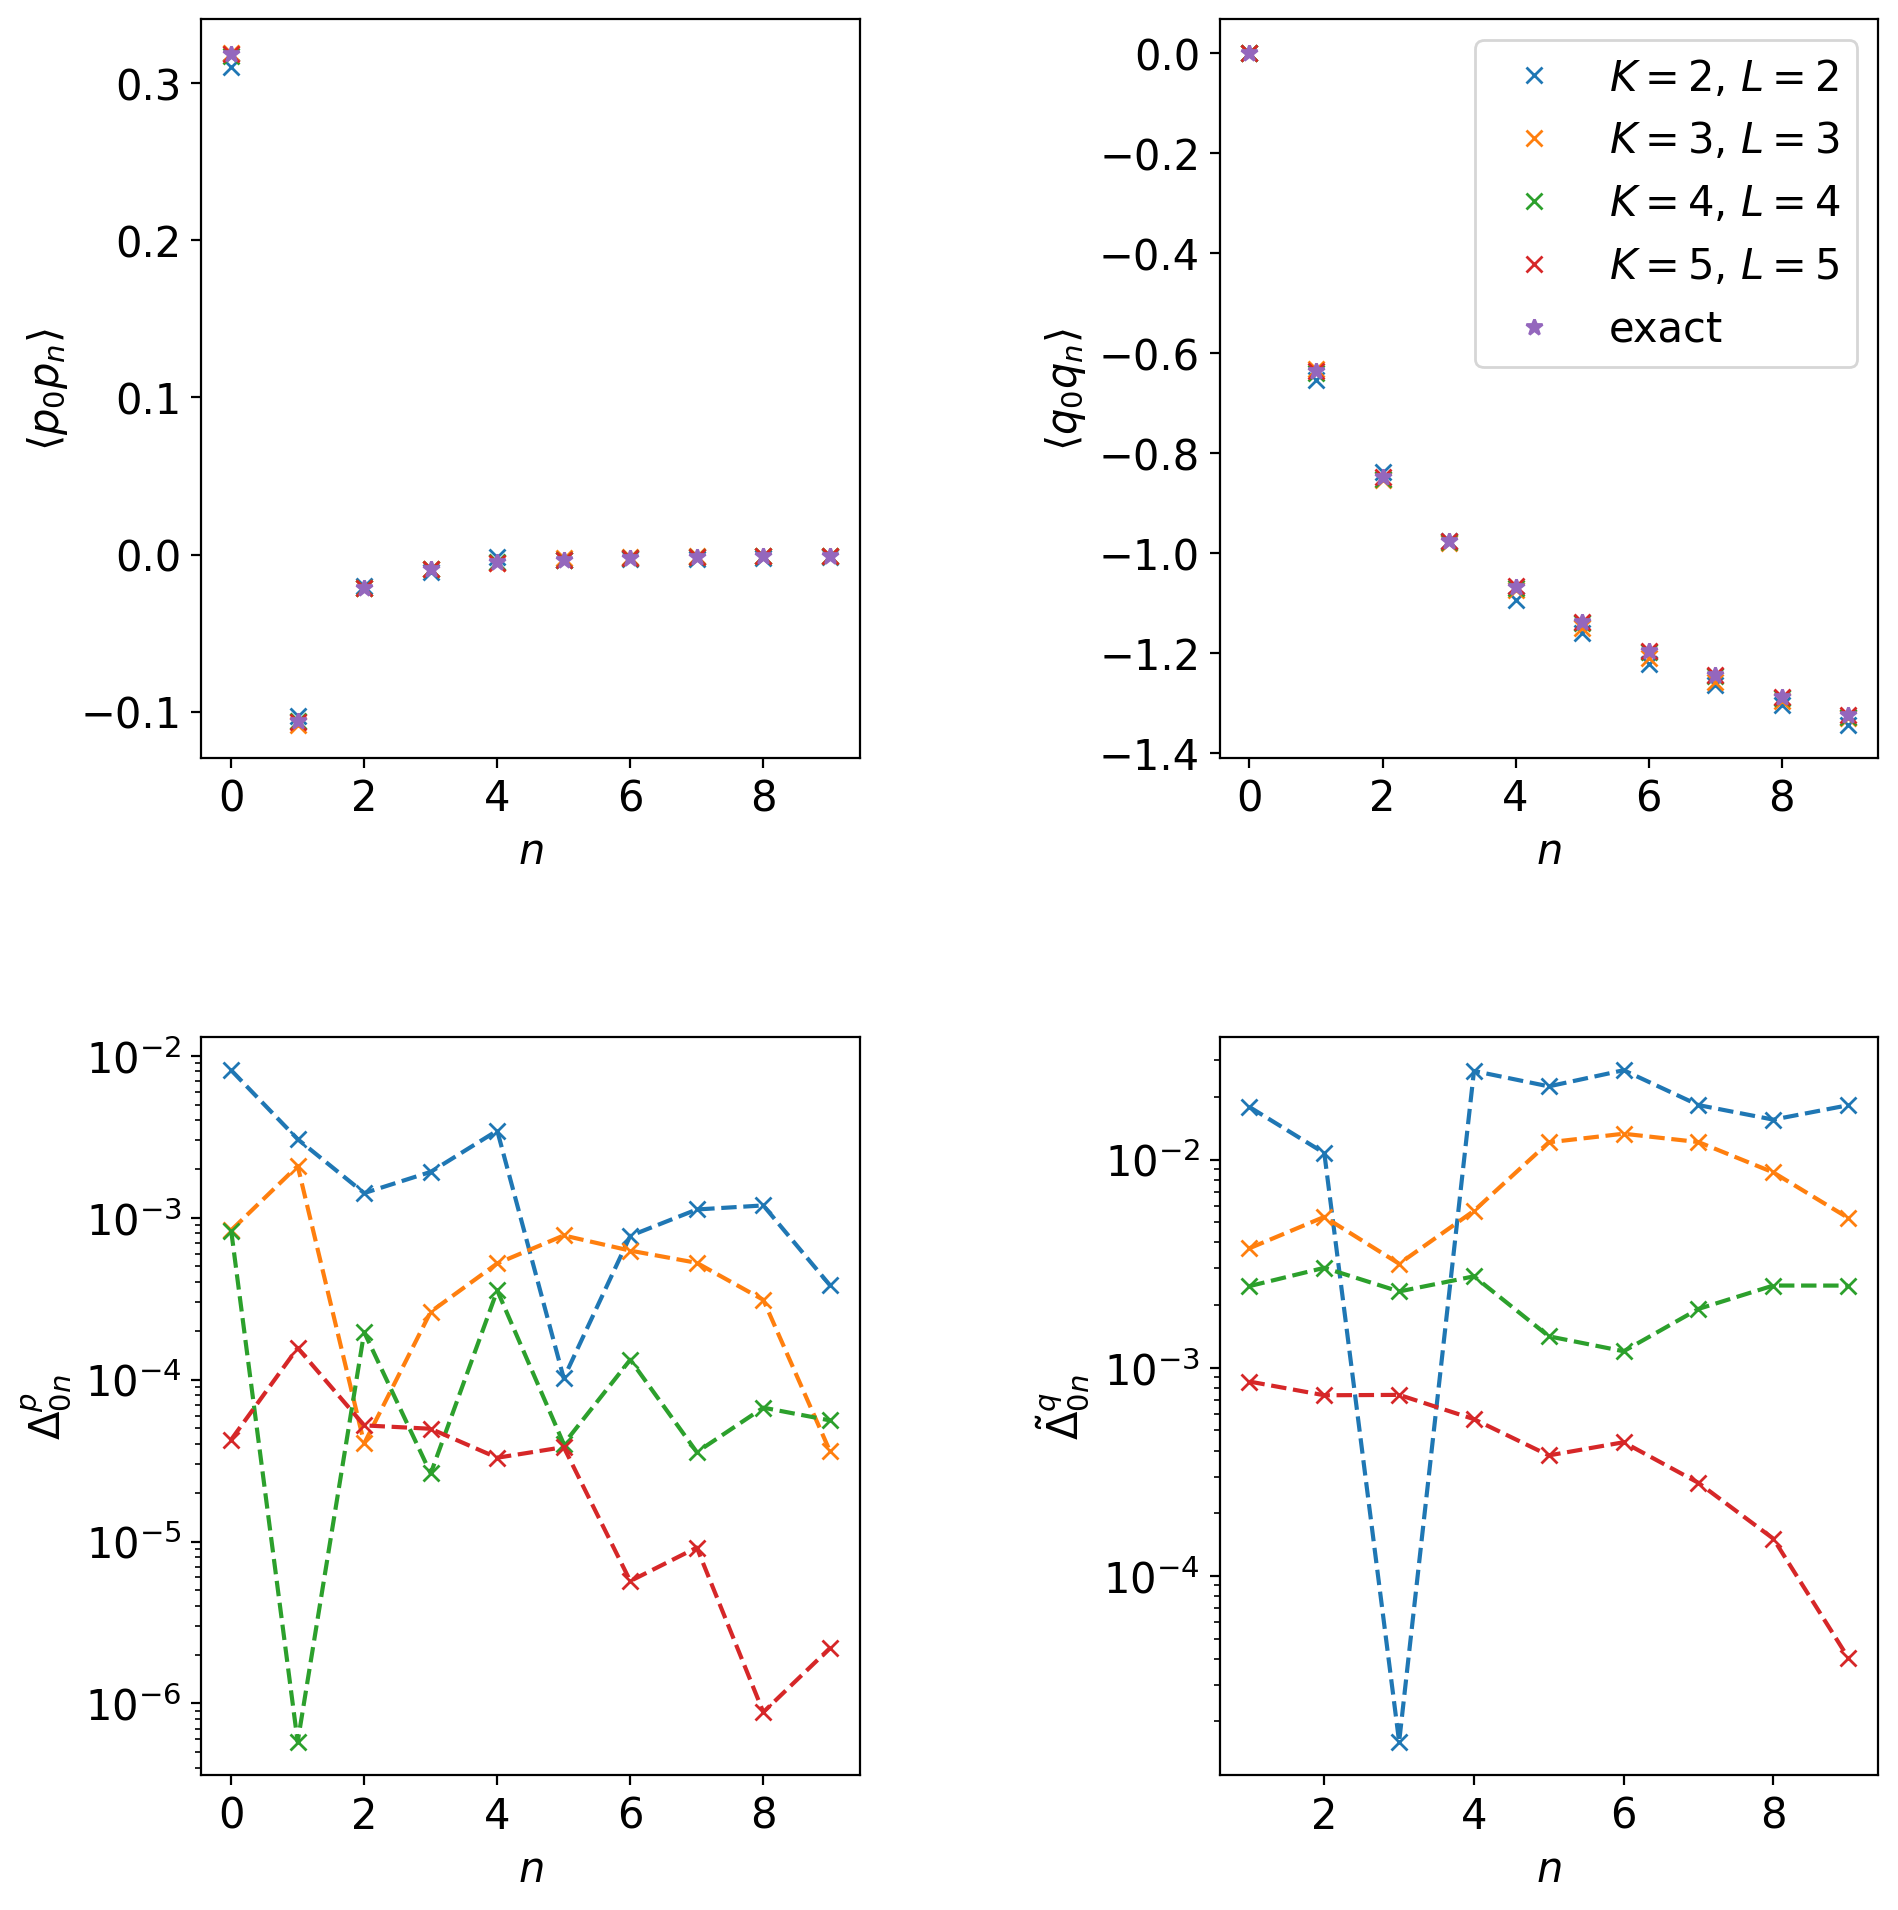

In [9]:
N = 10
NUM_LAYERS = 20

font = {"family": "DejaVu Sans", "weight": "normal", "size": 15}
matplotlib.rc("font", **font)
fig, ax = plt.subplots(2, 2, figsize=(11, 11))

for par in [(2, 2), (3, 3), (4, 4), (5, 5)]:  # , (6, 6)]:
    # <pp> correlation function
    x = np.arange(N)
    m = bosonic_mera.selesnick(*par)
    Cp = m.p_covariance(N, NUM_LAYERS)
    ax[0, 0].plot(
        x, Cp[0, :], marker="x", linestyle="", label="$K = %d$, $L = %d$" % par
    )
    mera = Cp[0, :]
    exact = -1 / (4 * np.pi * (x ** 2 - 0.25))
    p = ax[1, 0].plot(
        x,
        np.abs(mera - exact),
        marker="x",
        linestyle="--",
        label="$K = %d$, $L = %d$" % par,
    )

    # <qq> correlation function
    Cq = m.q_covariance(N, NUM_LAYERS, regulate=True)
    ax[0, 1].plot(
        x, Cq[0, :], marker="x", linestyle="", label="$K = %d$, $L = %d$" % par
    )
    mera = Cq[0, :]
    exact = (
        -1
        / (2 * np.pi)
        * (
            scipy.special.digamma(0.5 + x)
            + scipy.special.digamma(0.5 - x)
            - scipy.special.digamma(0.5)
            - scipy.special.digamma(0.5)
        )
    )
    ax[1, 1].plot(
        x[1:],
        np.abs(mera - exact)[1:],
        marker="x",
        linestyle="--",
        label="$K = %d$, $L = %d$" % par,
    )
ax[0, 0].plot(
    x, -1 / (4 * np.pi * (x ** 2 - 0.25)), marker="*", linestyle="", label="exact"
)  # exact answer
ax[0, 0].set_xlabel(r"$n$")
ax[0, 0].set_ylabel(r"$\langle p_0 p_n \rangle$")

ax[0, 1].plot(
    x,
    -1
    / (2 * np.pi)
    * (
        scipy.special.digamma(0.5 + x)
        + scipy.special.digamma(0.5 - x)
        - scipy.special.digamma(0.5)
        - scipy.special.digamma(0.5)
    ),
    marker="*",
    linestyle="",
    label="exact",
)
ax[0, 1].set_xlabel(r"$n$")
ax[0, 1].set_ylabel(r"$\langle q_0 q_n \rangle$")
ax[0, 1].legend()

ax[1, 0].set_xlabel(r"$n$")
ax[1, 0].set_ylabel(r"$\Delta^p_{0n}$")
ax[1, 0].set_yscale("log")


ax[1, 1].set_xlabel(r"$n$")
ax[1, 1].set_ylabel(r"$\tilde\Delta^q_{0n}$")
ax[1, 1].set_yscale("log")


fig.tight_layout(pad=4.0)
fig.savefig("correlations.pdf")